                user id                                     tweets content  \
count             15050                                              15050   
unique               14                                              14976   
top     ChannelNewsAsia  RT @NBCNightlyNews: NOW: @LesterHoltNBC anchor...   
freq               1703                                                  4   
mean                NaN                                                NaN   
std                 NaN                                                NaN   
min                 NaN                                                NaN   
25%                 NaN                                                NaN   
50%                 NaN                                                NaN   
75%                 NaN                                                NaN   
max                 NaN                                                NaN   

             created on   clean_tweet  sentiment_classification

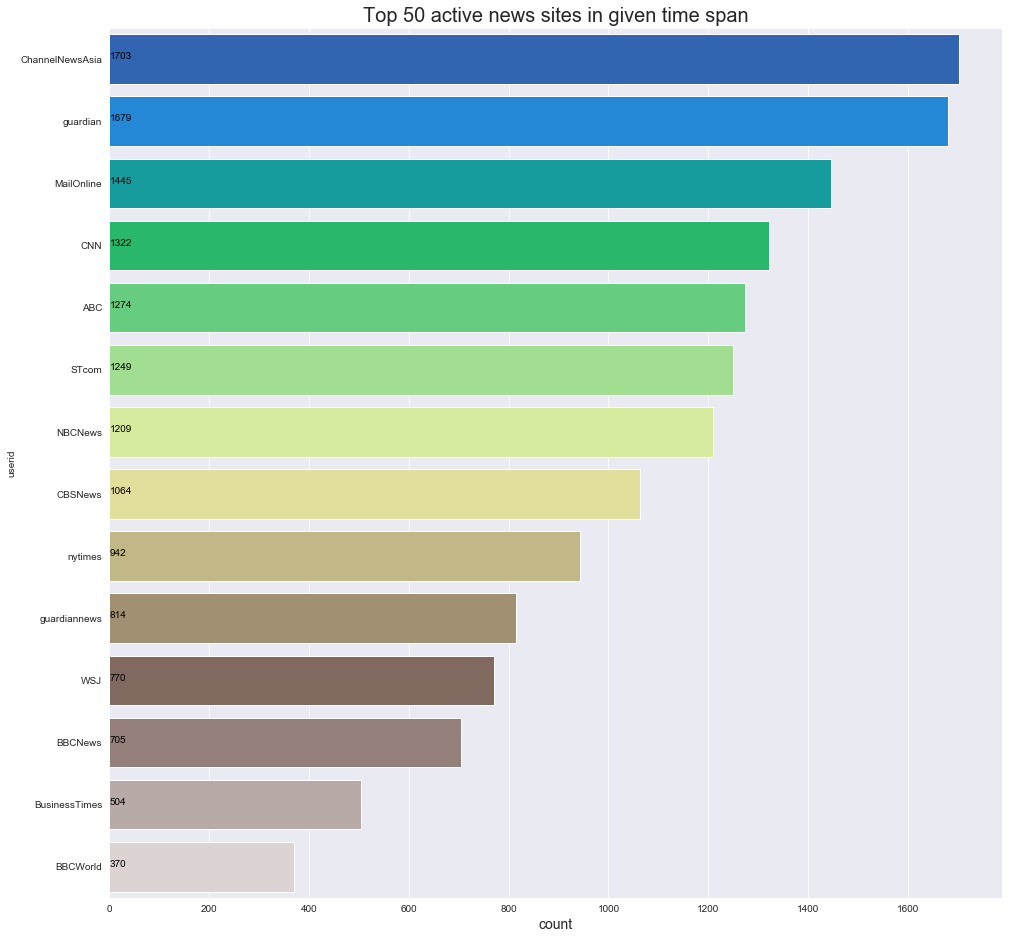

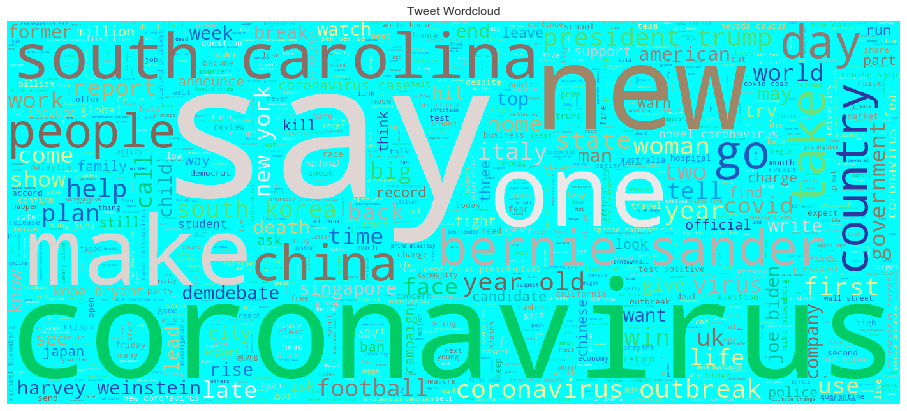

Inter Annotation Agreement - TextBlob:  0.06988847583643121
TextBlob Summary:                precision    recall  f1-score   support

          -1       0.43      0.27      0.33       632
           0       0.63      0.40      0.49      1205
           1       0.12      0.60      0.19       163

    accuracy                           0.37      2000
   macro avg       0.39      0.42      0.34      2000
weighted avg       0.52      0.37      0.42      2000

TextBlob Scores:  (0.5243592107136287, 0.3745, 0.415015328334115, None)
Inter Annotation Agreement - Vader:  0.1964203270719005
Vader Summary:                precision    recall  f1-score   support

          -1       0.54      0.64      0.58       632
           0       0.72      0.30      0.42      1205
           1       0.15      0.69      0.24       163

    accuracy                           0.44      2000
   macro avg       0.47      0.54      0.42      2000
weighted avg       0.62      0.44      0.46      2000

Vader Scores:  

KeyboardInterrupt: 

In [4]:
import re
import pandas as pd
import numpy as np
from pprint import pprint
import spacy
import os
import multiprocessing
from time import time
import datetime

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel, Word2Vec

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import pyLDAvis
import pyLDAvis.gensim

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score, classification_report, cohen_kappa_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.pipeline import Pipeline

import logging
logging.basicConfig(format="%(asctime)s : %(levelname)s : %(message)s", level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

sns.set_style("darkgrid")

def main():
    def drawbarplot(x, y, xlabel, title, figsize = (10,10)):
        plt.figure(figsize = figsize)
        sns.barplot(x = x, y = y, palette = 'terrain', orient = 'h', order = y)
        for i,v in enumerate(x):
            plt.text(0.8, i, v, color = 'k', fontsize = 10)

        plt.title(title, fontsize = 20)
        plt.xlabel(xlabel, fontsize = 14)
        plt.show()

    def textblob_sentiment(tweet):
        analysis = TextBlob(str(tweet))
        s_score = analysis.sentiment.polarity
        
        if s_score > 0:
            s_score = '1'
        elif s_score == 0:
            s_score = '0'
        elif s_score < 0:
            s_score = '-1'
        return s_score
    
    def vader_sentiment(tweet: str) -> float:
        vader = SentimentIntensityAnalyzer()
        
        v_score = vader.polarity_scores(tweet)['compound']
        if v_score > 0:
            v_score = '1'
        elif v_score == 0:
            v_score = '0'
        elif v_score < 0:
            v_score = '-1'
        return v_score
    
    def svm(tweet: str) -> pd.DataFrame:
        
        pipeline = Pipeline(
            [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(
                loss='hinge',
                penalty='l2',
                alpha=1e-3,
                random_state=42,
                max_iter=100,
                learning_rate='optimal',
                tol=None,
                )),
            ]
        )
        learner = pipeline.fit(tweet.iloc[:2000,3].fillna(' '), tweet.iloc[:2000,4])
        test_df = learner.predict(tweet.iloc[:,3].fillna(' '))
        return test_df
    
    def logreg(tweet: str) -> pd.DataFrame:
        
        pipeline = Pipeline(
            [
                ('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(solver='liblinear', multi_class='auto')),
            ]
        )
        learner = pipeline.fit(tweet.iloc[:2000,3].fillna(' '), tweet.iloc[:2000,4])
        test_df = learner.predict(tweet.iloc[:,3].fillna(' '))
        return test_df
    
    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN','ADJ','VERB','ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out

    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

    def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
        coherence_values = []
        model_list = []

        for num_topics in range(start, limit, step):
            # model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
            model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)

            model_list.append(model)

            coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')

            coherence_values.append(coherencemodel.get_coherence())

        return model_list, coherence_values

    def format_topics_sentences(ldamodel, corpus, texts):
        sent_topics_df = pd.DataFrame()

        for i,row in enumerate(ldamodel[corpus]):
            row = sorted(row, key=lambda x: (x[1]), reverse=True)

            for j, (topic_num, prop_topic) in enumerate(row):
                if j == 0:
                    wp = ldamodel.show_topic(topic_num)
                    topic_keywords = ", ".join([word for word, prop in wp])
                    sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index = True)
                else:
                    break
    
        sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

        contents = pd.Series(texts)
        sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
        return(sent_topics_df)

    def tsnescatterplot(model, word, list_names):
        arrays = np.empty((0, 300), dtype = 'f')
        word_labels = [word]
        color_list = ['red']

        arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)

        close_words = model.wv.most_similar([word])

        for wrd_score in close_words:
            wrd_vector = model.wv.__getitem__([wrd_score[0]])
            word_labels.append(wrd_score[0])
            color_list.append('blue')
            arrays = np.append(arrays, wrd_vector, axis=0)

        for wrd in list_names:
            wrd_vector = model.wv.__getitem__([wrd])
            word_labels.append(wrd)
            color_list.append('green')
            arrays = np.append(arrays, wrd_vector, axis=0)

        reduc = PCA(n_components=1).fit_transform(arrays)

        np.set_printoptions(suppress=True)

        Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)

        df = pd.DataFrame({'x': [x for x in Y[:,0]],
                           'y': [y for y in Y[:,1]],
                           'words': word_labels,
                           'color': color_list})

        fig, _ = plt.subplots()
        fig.set_size_inches(9, 9)

        p1 = sns.regplot(data=df,
                         x="x",
                         y="y",
                         fit_reg=False,
                         marker="o",
                         scatter_kws={'s': 40,
                                      'facecolors': df['color']
                                      }
                         )

        for line in range(0, df.shape[0]):
            p1.text(df["x"][line],
                    df["y"][line],
                    ' ' + df["words"][line].title(),
                    horizontalalignment='left',
                    verticalalignment='bottom',
                    size='medium',
                    color=df['color'][line],
                    weight='normal'
                    ).set_size(15)

        plt.xlim(Y[:, 0].min()-50, Y[:,0].max()+50)
        plt.ylim(Y[:, 1].min()-50, Y[:,1].max()+50)

        plt.title('t-SNE Visualization for {}'.format(word.title()))
        
############################################################################################################################################
##############################################################   EDA   ###############################################################

    pd.options.display.width = 0
    
    df = pd.read_csv('finalOutput_manual_score.csv')
    
    pprint(df.describe(include='all'))
    
    count = df['user id'].value_counts()
    df_count = pd.DataFrame()
    df_count['userid'] = count.index
    df_count['activeCount'] = count.values
    df_count = df_count.iloc[:50,:]
    drawbarplot(x = df_count.activeCount, y = df_count.userid, xlabel = 'count', title = 'Top 50 active news sites in given time span', figsize = (16,16))

    wc = WordCloud(height = 600, repeat = False, width = 1400, max_words = 1000, colormap = 'terrain', background_color = 'Cyan', mode = 'RGBA').generate(' '.join(df['clean_tweet'].dropna().astype(str)))
    plt.figure(figsize = (16,16))
    plt.imshow(wc)
    plt.title('Tweet Wordcloud')
    plt.axis('off')
    plt.show()
    
############################################################################################################################################
##############################################################   Sentiment Analysis   ################################################################

    data = df.iloc[:,3].values.tolist()
    
    df["textblob_analysis"] = df.iloc[:,3]
    df["textblob_analysis"] = df["textblob_analysis"].apply(lambda x: textblob_sentiment(x))
    
    df["vader_analysis"] = df.iloc[:,3].astype(str)
    df["vader_analysis"] = df["vader_analysis"].apply(lambda x: vader_sentiment(x))
    
    df["logreg_analysis"] = logreg(df)
    
    df["svm_analysis"] = svm(df)
    
    df.to_csv("finalOutput_scored.csv",index=False)
    
    
    
############################################################################################################################################
##############################################################   COHEN'S KAPP - INTER ANNOTATION   ################################################################
    
    manual_score = df['sentiment_classification']
    textblob_score = df['textblob_analysis']
    vader_score = df["vader_analysis"]
    lr_score = df["logreg_analysis"]
    svm_score = df["svm_analysis"]
    
    select_manual = manual_score.iloc[:2000,].astype(int)
    select_blob = textblob_score.iloc[:2000,].astype(int)
    select_vader = vader_score.iloc[:2000,].astype(int)
    select_lr = lr_score.iloc[:2000,].astype(int)
    select_svm = svm_score.iloc[:2000,].astype(int)
    
    cohen_kappa_tb = cohen_kappa_score(select_manual, select_blob)
    cohen_kappa_vd = cohen_kappa_score(select_manual, select_vader)
    cohen_kappa_lr = cohen_kappa_score(select_manual, select_lr)
    cohen_kappa_svm = cohen_kappa_score(select_manual, select_svm)
    
    print("Inter Annotation Agreement - TextBlob: ", cohen_kappa_tb.astype(str))
    print("TextBlob Summary: ", classification_report(select_manual, select_blob))
    print("TextBlob Scores: ", precision_recall_fscore_support(select_manual, select_blob, average='weighted'))
    
    print("Inter Annotation Agreement - Vader: ", cohen_kappa_vd.astype(str))
    print("Vader Summary: ", classification_report(select_manual, select_vader))
    print("Vader Scores: ", precision_recall_fscore_support(select_manual, select_vader, average='weighted'))
    
    print("Inter Annotation Agreement - Logistic Regression: ", cohen_kappa_lr.astype(str))
    print("Logistic Regression Summary: ", classification_report(select_manual, select_lr))
    print("Logistic Regression Scores: ", precision_recall_fscore_support(select_manual, select_lr, average='weighted'))
    
    print("Inter Annotation Agreement - SVM: ", cohen_kappa_svm.astype(str))
    print("SVM Summary: ", classification_report(select_manual, select_svm))
    print("SVM Scores: ", precision_recall_fscore_support(select_manual, select_svm, average='weighted'))
    
    ##Comment Out section for ensemble prediction if running without the finalOutput_scored_ensemblePredicted.csv
    df_en = pd.read_csv('finalOutput_scored_ensemblePredicted.csv')
    
    en_score = df_en["ensemble_predict"]
    select_en = en_score.iloc[:2000,].astype(int)
    cohen_kappa_en = cohen_kappa_score(select_manual, select_en)
    print("Inter Annotation Agreement - Ensemble Learning: ", cohen_kappa_en.astype(str))
    print("Ensemble Learning Summary: ", classification_report(select_manual, select_en))
    print("Ensemble Learning Scores: ", precision_recall_fscore_support(select_manual, select_en, average='weighted'))
    
############################################################################################################################################
##############################################################   LDA MODELLING   ################################################################
    
    data_words = list(sent_to_words(data))

    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words_bigrams = make_bigrams(data_words)

    nlp = spacy.load('en', disable=['parser', 'ner'])

    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN','ADJ','VERB','ADV'])

    id2word = corpora.Dictionary(data_lemmatized)

    texts = data_lemmatized

    corpus = [id2word.doc2bow(text) for text in texts]

    pprint([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

#     lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                                id2word=id2word,
#                                                num_topics=26)

#     pprint(lda_model.print_topics())
#     doc_lda = lda_model[corpus]

#     coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     print('\nCoherence Score: ', coherence_lda)

#     os.environ.update({'MALLET_HOME':r'C:/Users/Daniel/Desktop/mallet-2.0.8/'})
#     mallet_path = 'C:/Users/Daniel/Desktop/mallet-2.0.8/bin/mallet'
#     ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

#     coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
#     coherence_ldamallet = coherence_model_ldamallet.get_coherence()

    model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

    limit=40
    start=2
    step=6

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence Score")
    plt.legend(("Coherence_values"), loc='best')
    plt.show()

    for m, cv in zip(x, coherence_values):
       print("Num Topics: = ", m, " has Coherence Value of ", round(cv,4))

    optimal_model = model_list[4]
    model_topics = optimal_model.show_topics(formatted=False)

    vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
    pyLDAvis.save_html(vis,'LDA_vis.html')

    pprint(optimal_model.print_topics(num_words=20))

    df_topic_sents_keywords = format_topics_sentences(optimal_model, corpus, data)

    df_dominant_topic = df_topic_sents_keywords.reset_index()
    df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contib', 'Keywords', 'Text']

    pprint(df_dominant_topic.head)

    sent_topics_sorteddf_mallet = pd.DataFrame()

    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
       sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contib', 'Keywords', 'Text']

    pprint(sent_topics_sorteddf_mallet)

    topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

    topic_contribution = round(topic_counts/topic_counts.sum(),4)

    topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

    df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

    df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

    pprint(df_dominant_topics)

############################################################################################################################################
##############################################################   WORD2VEC   ################################################################
        
    cores = multiprocessing.cpu_count()

    w2v_model = Word2Vec(min_count=20,
                         window=2,
                         size=300,
                         sample=6e-5,
                         alpha=0.03,
                         min_alpha=0.0007,
                         negative=20,
                         workers=cores-1)

    t = time()

    w2v_model.build_vocab(texts, progress_per=10000)

    pprint('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

    t = time()

    w2v_model.train(texts, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

    pprint('Time to train model: {} mins'.format(round((time() - t) / 60, 2)))

    w2v_model.init_sims(replace=True)

    pprint(w2v_model.wv.most_similar(positive=["coronavirus"]))

    tsnescatterplot(w2v_model, 'coronavirus', ['trump', 'tennis', 'virus', 'disease', 'money', 'woman', 'die', 'game'])
    
    tsnescatterplot(w2v_model, 'coronavirus', [i[0] for i in w2v_model.most_similar(negative=['coronavirus'])])
    
if __name__ == "__main__":
    main()
